In [28]:
from matplotlib import pyplot as plt
import numpy as np
import os
import random

import joblib
import keras
import time
from one_dollar_two import return_accuracy, return_time

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import a lot of things from keras:
# sequential model
from keras.models import Sequential

# layers
from keras.layers import Input, Dense, LSTM

# loss function
from keras.metrics import categorical_crossentropy

# callback functions
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# convert data to categorial vector representation
from keras.utils import to_categorical

# nice progress bar for loading data
from tqdm.notebook import tqdm

# helper function for train/test split
from sklearn.model_selection import train_test_split

# import confusion matrix helper function
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# resample signal to n samples
from scipy.signal import resample

# XML parser
import xml.etree.ElementTree as ET

# encoding and normalizing data
from sklearn.preprocessing import LabelEncoder, StandardScaler

NUM_POINTS = 50

In [29]:
data = []

for root, subdirs, files in os.walk('dataset/michael_dataset'):
    if 'ipynb_checkpoint' in root:
        continue
    
    if len(files) > 0:
        for f in tqdm(files):
            if '.xml' in f:
                fname = f.split('.')[0]
                label = fname[:-2]
                
                xml_root = ET.parse(f'{root}/{f}').getroot()
                
                points = []
                for element in xml_root.findall('Point'):
                    x = element.get('X')
                    y = element.get('Y')
                    points.append([x, y])
                    
                points = np.array(points, dtype=float)
                
                scaler = StandardScaler()
                points = scaler.fit_transform(points)
                
                resampled = resample(points, NUM_POINTS)
                
                data.append((label, resampled))

  0%|          | 0/160 [00:00<?, ?it/s]

In [30]:
print(data[0])
print(len(data))

('left_curly_brace_', array([[ 1.98921339,  0.4418769 ],
       [ 0.83998111,  2.02524415],
       [ 0.90766011,  1.61282119],
       [ 0.49187888,  1.82526091],
       [ 0.43682458,  1.61889989],
       [ 0.21409481,  1.68310732],
       [ 0.19235564,  1.50495303],
       [ 0.03683963,  1.47235052],
       [-0.01414859,  1.25961841],
       [-0.13374682,  1.16421278],
       [-0.14378101,  0.96249074],
       [-0.21967857,  0.84194845],
       [-0.19496078,  0.6601448 ],
       [-0.21633074,  0.54406358],
       [-0.19943135,  0.40865689],
       [-0.21118781,  0.30435823],
       [-0.2331992 ,  0.17176965],
       [-0.27623912,  0.10007361],
       [-0.34017894,  0.02305813],
       [-0.41281747,  0.00583261],
       [-0.60586742, -0.02395675],
       [-0.96590529, -0.04739461],
       [-1.26664237, -0.0577139 ],
       [-1.4711103 , -0.06682985],
       [-1.58818702, -0.0507642 ],
       [-1.61399231, -0.03893846],
       [-1.62253166, -0.00711835],
       [-1.56930322, -0.01037375]

## Let's have a look at our data

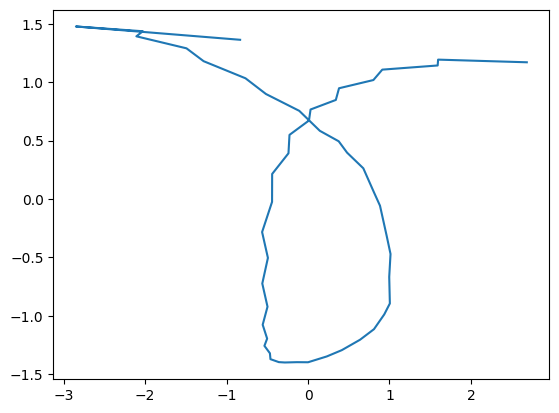

In [31]:
test_data = random.sample(data, 1)[0]

label = test_data[0]
sequence = test_data[1]
sequence

plt.plot(sequence.T[0], sequence.T[1]*-1)

In [32]:
# Prepare the data
labels = [sample[0] for sample in data]

print(set(labels))

encoder = joblib.load('label_encoder.pkl')

labels_encoded = encoder.fit_transform(labels)

print(set(labels_encoded))

y = to_categorical(labels_encoded)

print(len(y[0]))

sequences = [sample[1] for sample in data]
X = np.array(sequences)


{'star_', 'rectangle_', 'left_sq_bracket_', 'question_mark_', 'left_curly_brace_', 'triangle_', 'x_', 'check_', 'caret_', 'arrow_', 'right_sq_bracket_', 'pigtail_', 'right_curly_brace_', 'delete_mark_', 'circle_', 'v_'}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
16


In [33]:
# hier dann die modelle laden
model_one = keras.models.load_model('model_one.h5') #64
model_two = keras.models.load_model('model_two.h5') #32
model_three = keras.models.load_model('model_three.h5') #128


In [34]:
model_one.summary()
model_two.summary()
model_three.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,762 (77.20 KB)

 Trainable params: 19,760 (77.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         4,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,066 (23.70 KB)

 Trainable params: 6,064 (23.69 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 16)             │           528 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,730 (280.20 KB)

 Trainable params: 71,728 (280.19 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

### Model One 64 Layers

In [35]:
correct_predictions = 0
total_attempts = 0
times = []

start_time = time.time()
for sample in data:
    label = sample[0]
    sequence = sample[1]
    sequence

    prediction = model_one.predict(np.array([sequence])) # hier model ändern
    prediction = np.argmax(prediction)

    prediction_label = encoder.inverse_transform(np.array([prediction]))[0]
    
    if label == prediction_label:
        correct_predictions += 1
    total_attempts += 1

end_time = time.time()
prediciton_time = end_time - start_time
times.append(prediciton_time)

accuracy_one = correct_predictions / total_attempts
mean_time_one = np.mean(times)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/ste

### Model Two 32 Layers

In [36]:
correct_predictions = 0
total_attempts = 0
times = []

start_time = time.time()
for sample in data:
    label = sample[0]
    sequence = sample[1]
    sequence

    prediction = model_one.predict(np.array([sequence])) # hier model ändern
    prediction = np.argmax(prediction)

    prediction_label = encoder.inverse_transform(np.array([prediction]))[0]
    
    if label == prediction_label:
        correct_predictions += 1
    total_attempts += 1

end_time = time.time()
prediciton_time = end_time - start_time
times.append(prediciton_time)

accuracy_two = correct_predictions / total_attempts
mean_time_two = np.mean(times)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
1

### Model Two 128 Layers

In [37]:
correct_predictions = 0
total_attempts = 0
times = []

start_time = time.time()
for sample in data:
    label = sample[0]
    sequence = sample[1]
    print(sequence)
    sequence

    prediction = model_one.predict(np.array([sequence])) # hier model ändern
    prediction = np.argmax(prediction)

    prediction_label = encoder.inverse_transform(np.array([prediction]))[0]
    
    if label == prediction_label:
        correct_predictions += 1
    total_attempts += 1

end_time = time.time()
prediciton_time = end_time - start_time
times.append(prediciton_time)

accuracy_three = correct_predictions / total_attempts
mean_time_three = np.mean(times)

[[ 1.98921339  0.4418769 ]
 [ 0.83998111  2.02524415]
 [ 0.90766011  1.61282119]
 [ 0.49187888  1.82526091]
 [ 0.43682458  1.61889989]
 [ 0.21409481  1.68310732]
 [ 0.19235564  1.50495303]
 [ 0.03683963  1.47235052]
 [-0.01414859  1.25961841]
 [-0.13374682  1.16421278]
 [-0.14378101  0.96249074]
 [-0.21967857  0.84194845]
 [-0.19496078  0.6601448 ]
 [-0.21633074  0.54406358]
 [-0.19943135  0.40865689]
 [-0.21118781  0.30435823]
 [-0.2331992   0.17176965]
 [-0.27623912  0.10007361]
 [-0.34017894  0.02305813]
 [-0.41281747  0.00583261]
 [-0.60586742 -0.02395675]
 [-0.96590529 -0.04739461]
 [-1.26664237 -0.0577139 ]
 [-1.4711103  -0.06682985]
 [-1.58818702 -0.0507642 ]
 [-1.61399231 -0.03893846]
 [-1.62253166 -0.00711835]
 [-1.56930322 -0.01037375]
 [-1.39682035  0.00713474]
 [-1.19130674 -0.01220067]
 [-1.026829   -0.0056832 ]
 [-0.80230328 -0.07398411]
 [-0.62349165 -0.11811581]
 [-0.38240723 -0.24240313]
 [-0.19164482 -0.31437798]
 [ 0.06044229 -0.46909221]
 [ 0.18520209 -0.5316405 ]
 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
[[-1.05109195e+00  7.02297632e-01]
 [-1.26072686e+00  4.37826211e-01]
 [-1.20311491e+00  4.61649072e-01]
 [-1.23679641e+00  3.46777351e-01]
 [-1.21277152e+00  2.55786958e-01]
 [-1.23989097e+00  4.04359281e-02]
 [-1.23036508e+00 -1.27893881e-01]
 [-1.24051577e+00 -3.24159118e-01]
 [-1.23133959e+00 -4.96965977e-01]
 [-1.24031270e+00 -6.50140867e-01]
 [-1.21652865e+00 -7.51355611e-01]
 [-1.11260188e+00 -9.03125394e-01]
 [-9.23969230e-01 -1.03683815e+00]
 [-6.74443414e-01 -1.18624790e+00]
 [-3.73067707e-01 -1.29666413e+00]
 [-1.63842474e-01 -1.36822037e+00]
 [ 4.42530911e-02 -1.39740144e+00]
 [ 1.75210014e-01 -1.41834818e+00]
 [ 3.52636096e-01 -1.41931390e+00]
 [ 5.41238185e-01 -1.42264141e+00]
 [ 7.16454856e-01 -1.41796923e+00]
 [ 9.55745987e-01 -1.42500658e+00]
 [ 1.12627497e+00 -1.40182528e+00]
 [ 1.24579645e+00 -1.34841632e+00]
 [ 1.35977568e+00 -1.22486669e+00]
 [ 1.47893635e+00 -9.83288656e-01]
 [ 1.58075933e+00 -6.56118281e-01]
 [ 1.63966260e+00 

### 1 Dollar recognizer Data

In [38]:
time_dollar = return_time()
accuracy_dollar = return_accuracy()

## Task 2

## Paramaters
The parameter i changed (model.add(LSTM(64))) is the count of the layers used. I changed it from 64 to the half 32 and doubled it to 128.

### Prediction Time
in the following diagram is the prediction time of the 4 methods presented

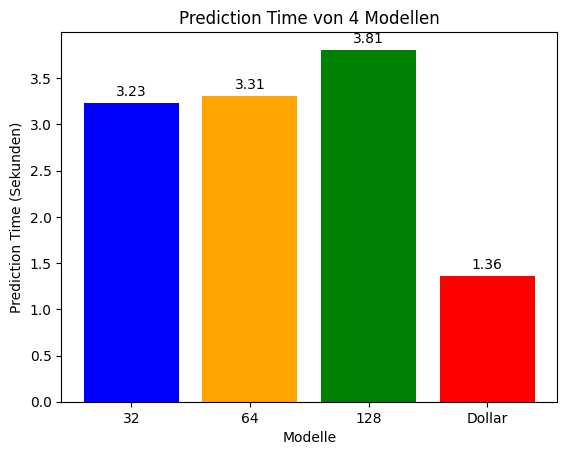

In [39]:
# Beispielwerte für Prediction Time von 4 Modellen
models = ['32', '64', '128', 'Dollar']
prediction_times = [mean_time_two, mean_time_one, mean_time_three, time_dollar]

fig, ax = plt.subplots()
bars = ax.bar(models, prediction_times, color=['blue', 'orange', 'green', 'red'])

# Titel und Achsenbeschriftungen hinzufügen
ax.set_title('Prediction Time von 4 Modellen')
ax.set_xlabel('Modelle')
ax.set_ylabel('Prediction Time (Sekunden)')

# Werte über den Balken anzeigen
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 Punkte Vertikalversatz
                textcoords="offset points",
                ha='center', va='bottom')

# Diagramm anzeigen
plt.show()


As shown above the time for the one dollar recognizer is the fastest to predict. Between the three LSTM methods, the more layers the faster it predicts. But its only differs by milliseconds. The 1 Dollar Recognizer is almost 2 seconds faster than the other.
### Accuracy
in the following diagram the accuracy of the different methods is shown

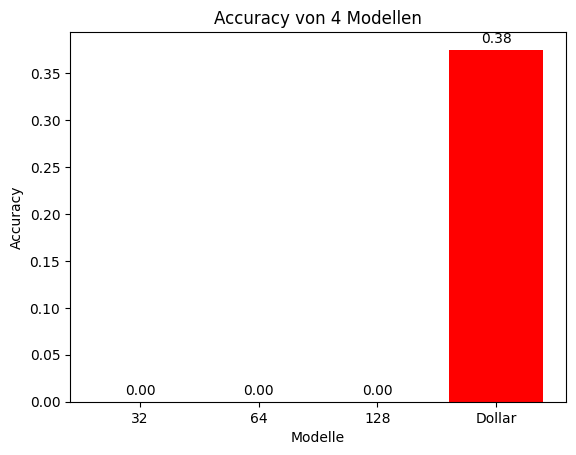

In [40]:
models = ['32', '64', '128', 'Dollar']
prediction_times = [accuracy_two, accuracy_one, accuracy_three, accuracy_dollar]

fig, ax = plt.subplots()
bars = ax.bar(models, prediction_times, color=['blue', 'orange', 'green', 'red'])

ax.set_title('Accuracy von 4 Modellen')
ax.set_xlabel('Modelle')
ax.set_ylabel('Accuracy')

# Werte über den Balken anzeigen
for bar in bars:
    height = bar.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 Punkte Vertikalversatz
                textcoords="offset points",
                ha='center', va='bottom')

# Diagramm anzeigen
plt.show()

The diagram shows that the accuracy is the same in the three LSTM modells. All of them are very accurate. The one Dollar Recognizer therefore leaks some accuracy by 40 %.

### Report

For an practical application u need to choose between the time and the accuracy, which of those values is more important. I prefer the higher accuracy before the faster prediction, since it is only faster by seconds.